In [22]:
#Imports
import numpy as np
import pandas as pd
import tensorflow.keras.backend as k
from sklearn.preprocessing import MinMaxScaler,  RobustScaler
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, losses, regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber



In [23]:
import numpy as np
import pandas as pd

# Read a specific sheet
df = pd.read_excel(r"MayniladDataSet.xlsx",
                   sheet_name='04-VAL04H-PM-1 MIRANDA-PSAN_Pre')

df.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,PMP,04-VAL04H-PM-1 MIRANDA-PSAN_Pressure,DATETIME,PSI
6,NaN,NaN,2022-01-01 00:00:00,[-11057] Not Enough Values For Calculation
7,NaN,NaN,2022-01-01 00:15:00,[-11057] Not Enough Values For Calculation
8,NaN,NaN,2022-01-01 00:30:00,[-11057] Not Enough Values For Calculation
9,NaN,NaN,2022-01-01 00:45:00,[-11057] Not Enough Values For Calculation


In [24]:
# Don't use this unless you're gonna change your prv dataset.
# to clean

df.drop(['Unnamed: 1', 'Unnamed: 0'], axis=1, inplace=True)
df.to_csv('Dataset.csv', index=False)
df.head(100)

,Unnamed: 2,Unnamed: 3
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
95,2022-01-01 22:15:00,[-11057] Not Enough Values For Calculation
96,2022-01-01 22:30:00,[-11057] Not Enough Values For Calculation
97,2022-01-01 22:45:00,[-11057] Not Enough Values For Calculation
98,2022-01-01 23:00:00,[-11057] Not Enough Values For Calculation


In [25]:
import numpy as np
import pandas as pd
#Cleaning changing Not enough values to NaN
df3 = pd.read_csv("Dataset.csv", skiprows=6)
df3.columns = ['DATETIME', 'PSI']
df3.replace('[-11057] Not Enough Values For Calculation', np.nan, inplace=True)
#changing data types

df3['PSI'] = pd.to_numeric(df3['PSI'], errors='coerce')
df3['DATETIME'] = pd.to_datetime(df3['DATETIME'], errors='coerce')
df3.dtypes
df3

,DATETIME,PSI
0,2022-01-01 00:00:00,NaN
1,2022-01-01 00:15:00,NaN
2,2022-01-01 00:30:00,NaN
3,2022-01-01 00:45:00,NaN
4,2022-01-01 01:00:00,NaN
...,...,...
101659,2024-11-24 22:45:00,7.81
101660,2024-11-24 23:00:00,9.23
101661,2024-11-24 23:15:00,9.94
101662,2024-11-24 23:30:00,8.52


In [26]:
# Creates a separate copy
df_new = df3.copy()  
# Set the index to the 'DATETIME' column
df_new.index = df_new['DATETIME'] 
df_new.drop('DATETIME', axis=1, inplace=True)

df_new




,PSI
DATETIME,
2022-01-01 00:00:00,NaN
2022-01-01 00:15:00,NaN
2022-01-01 00:30:00,NaN
2022-01-01 00:45:00,NaN
2022-01-01 01:00:00,NaN
...,...
2024-11-24 22:45:00,7.81
2024-11-24 23:00:00,9.23
2024-11-24 23:15:00,9.94


In [27]:
df_new.loc[df_new['PSI'] > 30, 'PSI'] = np.nan
df_new['PSI'] = df_new['PSI'].interpolate(method='time')
df_new['PSI'] = df_new['PSI'].rolling(window=5, center=True).median()

In [28]:
df_new.fillna(0, inplace=True)

df_new

,PSI
DATETIME,
2022-01-01 00:00:00,0.00
2022-01-01 00:15:00,0.00
2022-01-01 00:30:00,0.00
2022-01-01 00:45:00,0.00
2022-01-01 01:00:00,0.00
...,...
2024-11-24 22:45:00,8.52
2024-11-24 23:00:00,8.52
2024-11-24 23:15:00,9.23


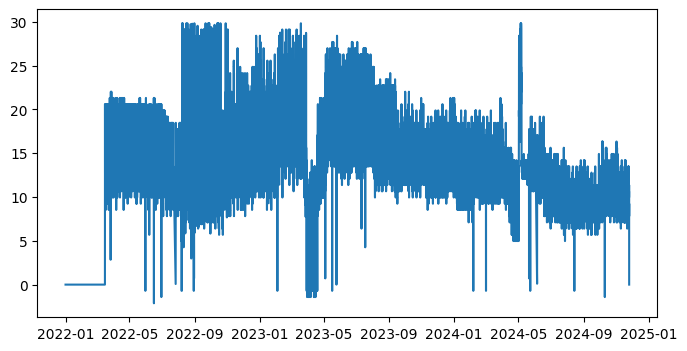

In [29]:
#visualizing my dataframe
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

# Plot using numerical indices on the x-axis
plt.plot(df_new.index, df_new['PSI'], label='PSI')
# Formatting




In [30]:
df_new['PSI']




DATETIME
2022-01-01 00:00:00    0.00
2022-01-01 00:15:00    0.00
2022-01-01 00:30:00    0.00
2022-01-01 00:45:00    0.00
2022-01-01 01:00:00    0.00
                       ... 
2024-11-24 22:45:00    8.52
2024-11-24 23:00:00    8.52
2024-11-24 23:15:00    9.23
2024-11-24 23:30:00    0.00
2024-11-24 23:45:00    0.00
Name: PSI, Length: 101664, dtype: float64

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
len(df_new)



101664

In [32]:
train = df_new.iloc[:81331]
test = df_new.iloc[81331:]
train

,PSI
DATETIME,
2022-01-01 00:00:00,0.00
2022-01-01 00:15:00,0.00
2022-01-01 00:30:00,0.00
2022-01-01 00:45:00,0.00
2022-01-01 01:00:00,0.00
...,...
2024-04-27 03:30:00,13.49
2024-04-27 03:45:00,12.78
2024-04-27 04:00:00,12.07


In [33]:
len(train)


81331

In [34]:
len(test)

20333

In [35]:
test

,PSI
DATETIME,
2024-04-27 04:45:00,10.65
2024-04-27 05:00:00,9.23
2024-04-27 05:15:00,9.23
2024-04-27 05:30:00,8.52
2024-04-27 05:45:00,7.81
...,...
2024-11-24 22:45:00,8.52
2024-11-24 23:00:00,8.52
2024-11-24 23:15:00,9.23


In [36]:
# scaling
scaler.fit(df_new)


MinMaxScaler()

In [37]:
scaled_data = scaler.transform(df_new)


In [38]:
def create_multi_step_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

In [52]:
INPUT_LENGTH = 120
OUTPUT_LENGTH = 60

X, y = create_multi_step_sequences(scaled_data, INPUT_LENGTH, OUTPUT_LENGTH)

# Reshape for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)    

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes
print("X_train shape:", X_train.shape)  # (samples, 180, 1)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)  # (samples, 30)
print("y_test shape:", y_test.shape)


X_train shape: (81188, 120, 1)
X_test shape: (20297, 120, 1)
y_train shape: (81188, 60, 1)
y_test shape: (20297, 60, 1)


In [80]:
# Install Keras Tuner if not already installed
# pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units in the first layer
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Tune the number of LSTM units in the second layer
    model.add(LSTM(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(OUTPUT_LENGTH))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

In [81]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='lstm_tuning'
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units_1')}.
The optimal number of units in the second LSTM layer is {best_hps.get('units_2')}.
The optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Trial 20 Complete [00h 10m 29s]
val_loss: 0.0036628679372370243

Best val_loss So Far: 0.0028007186483591795
Total elapsed time: 03h 16m 50s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
32                |64                |units_1
0.2               |0.3               |dropout_1
96                |64                |units_2
0.3               |0.2               |dropout_2
0.0001            |0.0005            |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 161s 63ms/step - loss: 0.0559 - mae: 0.1698 - val_loss: 0.0050 - val_mae: 0.0501
Epoch 2/4
2537/2538 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0146 - mae: 0.0894

KeyboardInterrupt: 

In [ ]:
#building model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(60) # Output layer with 60 units for the 60 time steps
])

In [ ]:
model.summary()

In [ ]:
# Compile model with Huber loss and Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

# Reduce LR if validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=5e-5, verbose=1)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    filepath="PredictONEhourTest.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[ reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/20
2537/2538 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0182 - mae: 0.0939
Epoch 1: val_loss improved from inf to 0.00433, saving model to PredictONEhourTest.keras
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 174s 67ms/step - loss: 0.0182 - mae: 0.0939 - val_loss: 0.0043 - val_mae: 0.0448 - learning_rate: 0.0050
Epoch 2/20
2537/2538 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0060 - mae: 0.0544
Epoch 2: val_loss did not improve from 0.00433
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 172s 68ms/step - loss: 0.0060 - mae: 0.0544 - val_loss: 0.0045 - val_mae: 0.0456 - learning_rate: 0.0050
Epoch 3/20
2537/2538 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0053 - mae: 0.0508
Epoch 3: val_loss improved from 0.00433 to 0.00304, saving model to PredictONEhourTest.keras
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 246s 97ms/step - loss: 0.0053 - mae: 0.0508 - val_loss: 0.0030 - val_mae: 0.0350 - learning_rate: 0.0050
Epoch 4/20
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0050 - mae: 0.0492
Epoch 4: val_loss did not i

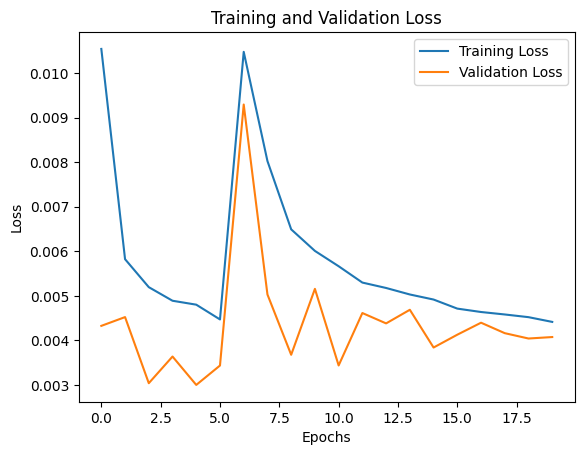

In [75]:
# Plot training and validation loss with a legend
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label='Training Loss')

val_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch, label='Validation Loss')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
best_model = load_model("PredictOneHour.keras")
y_pred = best_model.predict(X_test)

635/635 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step


In [77]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

In [78]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# SMAPE function (already defined in your code)
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))  # Avoid division by zero

# MAPE function (already defined in your code)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10)))  # Avoid division by zero

# Ensure y_test and y_pred have consistent shapes
if len(y_test.shape) == 3:  # If y_test is 3D (multi-step)
    y_test_flat = y_test[:, :, 0].flatten()  # Flatten the first feature
else:
    y_test_flat = y_test.flatten()

if len(y_pred.shape) == 3:  # If y_pred is 3D (multi-step)
    y_pred_flat = y_pred[:, :, 0].flatten()  # Flatten the first feature
else:
    y_pred_flat = y_pred.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
print(f'RMSE: {rmse:.4f}')

# Calculate MAPE
mape_value = mape(y_test_flat, y_pred_flat)
print(f'MAPE: {mape_value:.4f}%')

smape_value = smape(y_test_flat, y_pred_flat)
print(f'SMAPE: {smape_value:.4f}%')

mae = mean_absolute_error(y_test_flat, y_pred_flat)
print(f'MAE: {mae:.4f}')

RMSE: 0.0611
MAPE: 9.9985%
SMAPE: 8.7742%
MAE: 0.0355


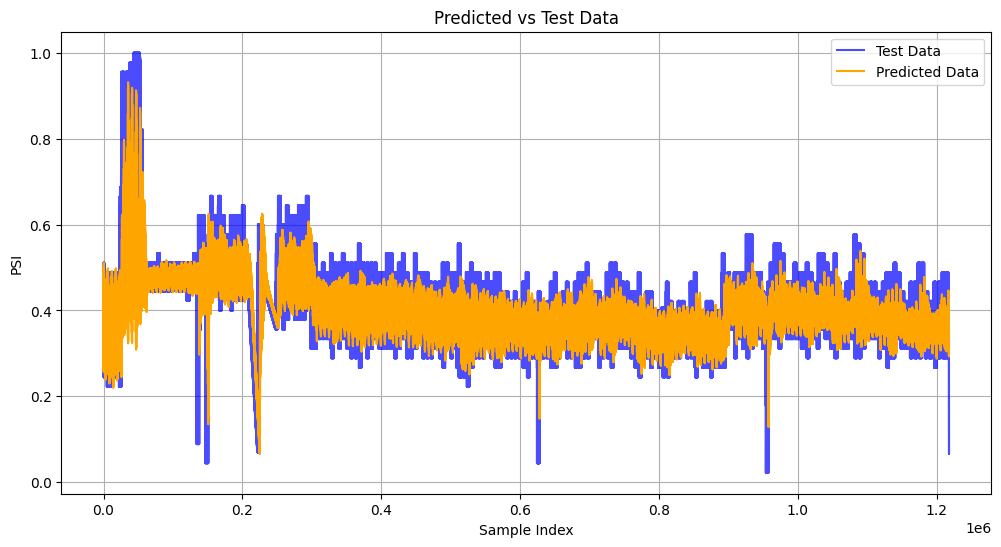

In [79]:
# Plot the test data and predictions
plt.figure(figsize=(12, 6))

# Use the range of y_test as indices
test_indices = range(len(y_test_flat))

plt.plot(test_indices, y_test_flat, label='Test Data', color='blue', alpha=0.7)
plt.plot(test_indices, y_pred_flat, label='Predicted Data', color='orange')

# Add labels, legend, and title
plt.xlabel('Sample Index')
plt.ylabel('PSI')
plt.title('Predicted vs Test Data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(y_test.shape)
print(y_pred.shape)

(20297, 60, 1)
(20297, 60)
